In [1]:
### --- Standard libraries ---
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import sys

### --- Genomic tools ---
import pysam
from pyfaidx import Fasta  # You'll use this later for sequence extraction

### --- Custom modules ---
#from dna_io import dna_1hot
from OccuFold.ml.funcs import dna_1hot
import OccuFold.ml.funcs as func
from OccuFold.ml.funcs import train_ctcf_model


### --- File paths ---
bind_sites_filepath = 'data/files/sonmezer_dataset_CTCT_binding.sites.filtered.mm10.tsv'
bind_freqs_filepath = 'data/files/binding.frequencies.tsv'
ref_genome_filepath = '/project/fudenber_735/genomes/mm10/mm10.fa' # You'll require the reference genome 


In [2]:
# processing & merging data

In [3]:
# Load reference genome
ref_genome = pysam.FastaFile(ref_genome_filepath)
# Load binding sites and frequency data
bind_sites = pd.read_table(bind_sites_filepath)
bind_freqs = pd.read_table(bind_freqs_filepath)

In [4]:
# Keep only TFBS clusters that have all 3 biological states, it is a way for validation
site_filter = []
for tfbs in bind_freqs['TFBS_cluster'].unique():
    if len(bind_freqs[bind_freqs['TFBS_cluster'] == tfbs]) == 3:
        site_filter.append(tfbs)

# Filter and rename
bind_sites = bind_sites[bind_sites.rownames.isin(site_filter)]
bind_sites_revised = bind_sites.rename(columns={'rownames': 'TFBS_cluster'})
bind_freqs_dtf = bind_freqs[bind_freqs.TFBS_cluster.isin(site_filter)]

In [5]:
# Merge with binding site coordinates
bind_freqs_pivot = bind_freqs_dtf.pivot_table(
    index='TFBS_cluster',
    columns='biological.state',
    values='Freqs',
    aggfunc='first'
)

# Reset index and reorder columns
bind_freqs_pivot.reset_index(inplace=True)
bind_freqs_pivot = bind_freqs_pivot[['TFBS_cluster', 'Accessible', 'Bound', 'Nucleosome.occupied']]
binds_sites_freqs = pd.merge(bind_sites_revised, bind_freqs_pivot, on='TFBS_cluster', how='left')


# Preview result
binds_sites_freqs.head()

,chrom,start,end,width,strand,score,phyloP,rmsk,name,isBound,TF,chipseq.score,TFBS_cluster,Accessible,Bound,Nucleosome.occupied
0,chr1,9541413,9541431,19,-,13.2902,-0.022579,False,CTCF,True,CTCF,401.092987,TFBS_1000,0.503958,0.226913,0.269129
1,chr1,9541469,9541487,19,-,13.2902,0.385316,False,CTCF,True,CTCF,401.092987,TFBS_1001,0.578275,0.271565,0.150160
2,chr1,9545334,9545352,19,-,17.1224,0.913684,False,CTCF,True,CTCF,255.647003,TFBS_1002,0.742331,0.214724,0.042945
3,chr1,11140105,11140123,19,-,13.0579,-0.025105,False,CTCF,True,CTCF,163.445999,TFBS_1005,0.390026,0.052430,0.557545
4,chr1,13500664,13500682,19,-,19.2467,-0.194895,False,CTCF,True,CTCF,299.652008,TFBS_1012,0.500000,0.032338,0.467662


In [6]:
# Load genome
fasta = Fasta(ref_genome_filepath)

# Function to get sequence for each row
def get_sequence(row):
    try:
        return fasta[row['chrom']][row['start']:row['end']].seq
    except KeyError:
        return 'N/A'  # Handle any missing chromosomes

# Apply the function to each row
binds_sites_freqs['sequence'] = binds_sites_freqs.apply(get_sequence, axis=1)

# Save to file with sequences included
binds_sites_freqs.to_csv('data/files/sites_with_freqs_and_seqs.tsv', sep='\t', index=False)

binds_sites_freqs[['chrom','start','end','sequence','Accessible', 'Bound', 'Nucleosome.occupied']].head()

,chrom,start,end,sequence,Accessible,Bound,Nucleosome.occupied
0,chr1,9541413,9541431,AGTGACACCTACTTGCCA,0.503958,0.226913,0.269129
1,chr1,9541469,9541487,AGTGACACCTACTTGCCA,0.578275,0.271565,0.150160
2,chr1,9545334,9545352,GCCGCCCTCTGCCGGTCT,0.742331,0.214724,0.042945
3,chr1,11140105,11140123,GCTGCCACCTTCTGTTTC,0.390026,0.052430,0.557545
4,chr1,13500664,13500682,ACTGCCCTCTGCTGGCTT,0.500000,0.032338,0.467662


In [8]:
model = train_ctcf_model(
    bedfile_path='data/files/sites_with_freqs_and_seqs.csv',
    ctcfpfm = 'data/files/MA0139.1.pfm',
    save_weights_path='data/files/flankcore_trained_weightsee.pt',
    use_kldiv=True,  # or False if you want cross-entropy
    epochs=25
)

/home1/rahmanin/start/polychrom/projects/Site_wise_occupancy/OccuFold/OccuFold/ml/funcs.py:15: RuntimeWarning: divide by zero encountered in log
  pwm = np.log((pfm/s) / background_frequency)
/home1/rahmanin/start/polychrom/projects/Site_wise_occupancy/OccuFold/OccuFold/ml/funcs.py:66: RuntimeWarning: invalid value encountered in multiply
  for i in range(seq.shape[1] - k + 1)
/home1/rahmanin/start/polychrom/projects/Site_wise_occupancy/OccuFold/OccuFold/ml/funcs.py:70: RuntimeWarning: invalid value encountered in multiply
  for i in range(seq.shape[1] - k + 1)
/home1/rahmanin/.conda/envs/openmm-env/lib/python3.7/site-packages/torch/nn/modules/conv.py:310: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:895.)
  self.padding, self.dilation, self.groups)


Epoch 1/25 | Train Loss: 0.2383 | Val Loss: 0.2164
Epoch 2/25 | Train Loss: 0.2031 | Val Loss: 0.1915
Epoch 3/25 | Train Loss: 0.1792 | Val Loss: 0.1740
Epoch 4/25 | Train Loss: 0.1656 | Val Loss: 0.1637
Epoch 5/25 | Train Loss: 0.1548 | Val Loss: 0.1560
Epoch 6/25 | Train Loss: 0.1495 | Val Loss: 0.1523
Epoch 7/25 | Train Loss: 0.1454 | Val Loss: 0.1510
Epoch 8/25 | Train Loss: 0.1437 | Val Loss: 0.1622
Epoch 9/25 | Train Loss: 0.1410 | Val Loss: 0.1491
Epoch 10/25 | Train Loss: 0.1380 | Val Loss: 0.1507
Epoch 11/25 | Train Loss: 0.1409 | Val Loss: 0.1483
Epoch 12/25 | Train Loss: 0.1372 | Val Loss: 0.1462
Epoch 13/25 | Train Loss: 0.1351 | Val Loss: 0.1482
Epoch 14/25 | Train Loss: 0.1334 | Val Loss: 0.1477
Epoch 15/25 | Train Loss: 0.1321 | Val Loss: 0.1466
Epoch 16/25 | Train Loss: 0.1324 | Val Loss: 0.1497
Epoch 17/25 | Train Loss: 0.1311 | Val Loss: 0.1471
Epoch 18/25 | Train Loss: 0.1307 | Val Loss: 0.1489
Epoch 19/25 | Train Loss: 0.1309 | Val Loss: 0.1459
Epoch 20/25 | Train L

In [17]:
predictedctcf = func.predict_ctcf_occupancy(
    ctcf_bed='data/files/sites_with_freqs_and_seqs.csv', ctcfpfm = 'data/files/MA0139.1.pfm', 
    model_weights_path='data/files/flankcore_trained_weightsee.pt', out_features=3
)

/home1/rahmanin/start/polychrom/projects/Site_wise_occupancy/OccuFold/OccuFold/ml/funcs.py:128: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  preds = F.softmax(preds)


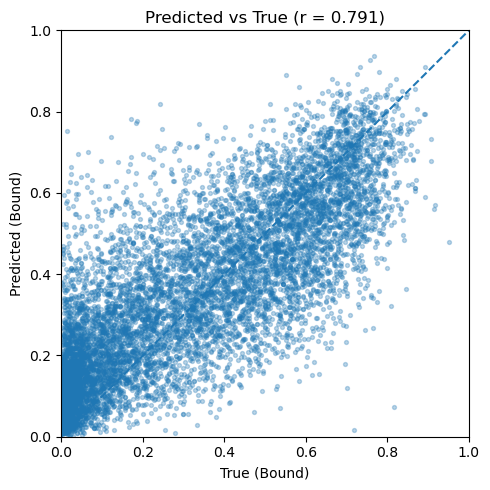

In [18]:
import numpy as np
import matplotlib.pyplot as plt

y_true = predictedctcf['Bound'].values          # ground truth (probability)
y_pred = predictedctcf['predicted_occupancy'].values

r = np.corrcoef(y_true, y_pred)[0, 1]

plt.figure(figsize=(5,5))
plt.scatter(y_true, y_pred, s=8, alpha=0.3)
plt.plot([0,1],[0,1],'--')
plt.xlim(0,1); plt.ylim(0,1)
plt.xlabel('True (Bound)')
plt.ylabel('Predicted (Bound)')
plt.title(f'Predicted vs True (r = {r:.3f})')
plt.tight_layout()
plt.show()
